# NeMo Curator Lab

**Assignment 2, Part a** | UC Berkeley EE 194/290-16: Scalable AI | Spring 2026

## Objective

In this assignment, students will use NeMo Curator to download and curate Wikipedia data within a chosen domain. Then, they will compare the non-curated data with the curated data and reason about how data curation may impact downstream tasks.

This assignment will be scored out of 70 points, with an opportunity to earn an additional 5 bonus points during the evaluation section. Refer to the headings for breakdowns of the scoring rubric.

**Deliverable**: Submit this notebook with all cells implemented and run, including each output per cell.

## Environment Setup [0 points]

Refer to Curator's [Installation Guide](https://docs.nvidia.com/nemo/curator/latest/admin/installation.html) to install and run Curator via Docker or `uv`. If using `uv`, include the `text_cuda12` extra (or install `all` which includes `text_cuda12`). Verify the environment and library setups with:

In [1]:
# verifies curator is installed
import nemo_curator

print(nemo_curator.__version__)

1.1.0rc0.dev0


In [2]:
!nvidia-smi

Thu Feb 26 00:37:18 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          Off |   00000000:04:00.0 Off |                    0 |
| N/A   31C    P0             67W /  700W |       1MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# verifies that gpu dependencies are installed
import cudf

print(cudf.__version__)

25.10.00


Initialize and start a Ray client:

In [4]:
from nemo_curator.core.client import RayClient

ray_client = RayClient(num_cpus=32)
ray_client.start()

2026-02-26 00:37:32.739 | WARNING  | nemo_curator.core.client:start:115 - No monitoring services are running. Please run the `start_prometheus_grafana.py` script from nemo_curator/metrics folder to setup monitoring services separately.
2026-02-26 00:37:32.780 | INFO     | nemo_curator.core.utils:init_cluster:185 - Ray start command: ray start --head --node-ip-address 10.128.0.20 --port 6379 --metrics-export-port 8081 --dashboard-host 127.0.0.1 --dashboard-port 8265 --ray-client-server-port 10001 --temp-dir /tmp/ray --disable-usage-stats --num-cpus 32 --block
2026-02-26 00:37:32.781 | DEBUG    | nemo_curator.core.utils:check_ray_responsive:38 - Verifying Ray cluster is responsive, using RAY_ADDRESS=10.128.0.20:6379
2026-02-26 00:37:32.782 | DEBUG    | nemo_curator.core.utils:check_ray_responsive:45 - running 'ray status' command


2026-02-26 00:37:34,639	INFO usage_lib.py:447 -- Usage stats collection is disabled.
2026-02-26 00:37:34,639	INFO scripts.py:919 -- Local node IP: 10.128.0.20


2026-02-26 00:37:36.386 | DEBUG    | nemo_curator.core.utils:check_ray_responsive:70 - Ray cluster is not responsive ('ray status' command failed)
2026-02-26 00:37:36.888 | DEBUG    | nemo_curator.core.utils:check_ray_responsive:45 - running 'ray status' command
2026-02-26 00:37:39.347 | DEBUG    | nemo_curator.core.utils:check_ray_responsive:58 - Ray cluster is not responsive ('No cluster status' returned or Error in output)
2026-02-26 00:37:39.848 | DEBUG    | nemo_curator.core.utils:check_ray_responsive:45 - running 'ray status' command


2026-02-26 00:37:39,835	SUCC scripts.py:963 -- --------------------
2026-02-26 00:37:39,835	SUCC scripts.py:964 -- Ray runtime started.
2026-02-26 00:37:39,835	SUCC scripts.py:965 -- --------------------
2026-02-26 00:37:39,835	INFO scripts.py:967 -- Next steps
2026-02-26 00:37:39,836	INFO scripts.py:970 -- To add another node to this Ray cluster, run
2026-02-26 00:37:39,836	INFO scripts.py:973 --   ray start --address='10.128.0.20:6379'
2026-02-26 00:37:39,836	INFO scripts.py:982 -- To connect to this Ray cluster:
2026-02-26 00:37:39,836	INFO scripts.py:984 -- import ray
2026-02-26 00:37:39,836	INFO scripts.py:985 -- ray.init(_node_ip_address='10.128.0.20')
2026-02-26 00:37:39,836	INFO scripts.py:997 -- To submit a Ray job using the Ray Jobs CLI:
2026-02-26 00:37:39,836	INFO scripts.py:998 --   RAY_API_SERVER_ADDRESS='http://127.0.0.1:8265' ray job submit --working-dir . -- python my_script.py
2026-02-26 00:37:39,836	INFO scripts.py:1007 -- See https://docs.ray.io/en/latest/cluster/ru

2026-02-26 00:37:42.150 | DEBUG    | nemo_curator.core.utils:check_ray_responsive:58 - Ray cluster is not responsive ('No cluster status' returned or Error in output)
2026-02-26 00:37:42.651 | DEBUG    | nemo_curator.core.utils:check_ray_responsive:45 - running 'ray status' command
2026-02-26 00:37:44.914 | DEBUG    | nemo_curator.core.utils:check_ray_responsive:66 - Ray cluster IS responsive


Note: If you encounter out of memory errors while downloading the data, then you may need to stop the Ray client (with `ray_client.stop()`), reduce `num_cpus` above, and start a fresh Ray client.

## Data Setup [5 points]

Use the following code to download and extract data from the latest Wikipedia dump. Limit it to English text only.

You are encouraged to experiment with the URL limit and record limit. Some helpful information:
- There are ~70 URLs per dump
- The number of JSONL files written == `url_limit`
- There are ~20,000 records per URL
- The number of rows per JSONL file == `record_limit`

In [5]:
from nemo_curator.stages.text.download.wikipedia.stage import WikipediaDownloadExtractStage

language = "en"  # do not change this
download_dir = "./wiki_downloads"
url_limit = 2  # experiment with this
record_limit = 100  # experiment with this
# Initialize the Wikipedia download stage
wiki_stage = WikipediaDownloadExtractStage(
    language=language,
    download_dir=download_dir,
    url_limit=url_limit,
    record_limit=record_limit,
)


In [6]:
from nemo_curator.stages.text.io.writer.jsonl import JsonlWriter

wiki_data_dir = "./wiki_data"

# Initialize the JSONL writer stage
jsonl_writer = JsonlWriter(wiki_data_dir, write_kwargs={"force_ascii": False})

In [7]:
from nemo_curator.pipeline import Pipeline

# Initialize the pipeline
pipeline = Pipeline("download_wiki_pipeline")

# Add the stages to the pipeline
pipeline.add_stage(wiki_stage)
pipeline.add_stage(jsonl_writer)

2026-02-26 00:37:53.966 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'wikipedia_en_pipeline' to pipeline 'download_wiki_pipeline'
2026-02-26 00:37:53.967 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'jsonl_writer' to pipeline 'download_wiki_pipeline'


Pipeline(name='download_wiki_pipeline', stages=[wikipedia_en_pipeline(WikipediaDownloadExtractStage), jsonl_writer(JsonlWriter)])

In [8]:
# Run the pipeline
results = pipeline.run()

2026-02-26 00:37:56.157 | INFO     | nemo_curator.pipeline.pipeline:build:70 - Planning pipeline: download_wiki_pipeline
2026-02-26 00:37:56.158 | INFO     | nemo_curator.pipeline.pipeline:_decompose_stages:106 - Decomposing composite stage: wikipedia_en_pipeline
2026-02-26 00:37:56.158 | INFO     | nemo_curator.pipeline.pipeline:_decompose_stages:120 - Expanded 'wikipedia_en_pipeline' into 3 execution stages
2026-02-26 00:37:56.332 | INFO     | nemo_curator.backends.xenna.executor:execute:135 - Execution mode: STREAMING
2026-02-26 00:37:56,333	INFO worker.py:1696 -- Using address 10.128.0.20:6379 set in the environment variable RAY_ADDRESS
2026-02-26 00:37:56,342	INFO worker.py:1837 -- Connecting to existing Ray cluster at address: 10.128.0.20:6379...
2026-02-26 00:37:56,356	INFO worker.py:2014 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
/home/sanjay/ee194-a2/Curator/.venv/lib/python3.10/site-packages/ray/_private/worker.py:2062: FutureWarning: Tip: In future ve

## Implement a Stage [10 points]

Use the code snippet below to read and inspect a portion of the dataset:

In [9]:
import pandas as pd
from nemo_curator.utils.file_utils import get_all_file_paths_under

# Read and inspect the first JSONL file from wiki_data_dir
file_paths = get_all_file_paths_under(wiki_data_dir)
df = pd.read_json(file_paths[0], lines=True)
df.head(10)

,text,title,id,url,language,source_id,file_name
0,A hotline is a point-to-point communications l...,Hotline,41243,https://en.wikipedia.org/wiki/Hotline,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...
1,"In biology, a hybrid is the offspring resultin...",Hybrid (biology),41244,https://en.wikipedia.org/wiki/Hybrid%20%28biol...,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...
2,"In telecommunications, a hybrid balance is an ...",Hybrid balance,41245,https://en.wikipedia.org/wiki/Hybrid%20balance,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...
3,A hybrid transformer (also known as a bridge t...,Hybrid transformer,41246,https://en.wikipedia.org/wiki/Hybrid%20transfo...,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...
4,Hydroxyl ion absorption is the absorption in o...,Hydroxyl ion absorption,41248,https://en.wikipedia.org/wiki/Hydroxyl%20ion%2...,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...
5,An identifier is a name that identifies (that ...,Identifier,41250,https://en.wikipedia.org/wiki/Identifier,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...
6,"In telecommunications and antenna design, an i...",Image antenna,41251,https://en.wikipedia.org/wiki/Image%20antenna,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...
7,Improved-definition television (IDTV) or enhan...,Improved-definition television,41254,https://en.wikipedia.org/wiki/Improved-definit...,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...
8,"In optics, an index-matching material is a sub...",Index-matching material,41256,https://en.wikipedia.org/wiki/Index-matching%2...,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...
9,"In electrical engineering, two conductors are ...",Inductive coupling,41258,https://en.wikipedia.org/wiki/Inductive%20coup...,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...


In the Wikipedia dataset, the last portion of the document's text typically corresponds "Categories" section of the Wikipedia page. For example, the text for the Wikipedia page on [Anarchism](https://en.wikipedia.org/wiki/Anarchism) looks like:

```text
Anarchism is a political philosophy and movement... \n\nExternal links \n\n Anarchy Archives – an online research center on the history and theory of anarchism.\n\n \nAnti-capitalism\nAnti-fascism\nEconomic ideologies\nFar-left politics\nLeft-wing ideologies\nLibertarian socialism\nLibertarianism\nPolitical culture\nPolitical ideologies\nPolitical movements\nSocial theories\nTypes of socialism
```

where `\n\n` denotes a new section on the page, and the last section of the page is a list of categories (in the above example, the categories are Anti-capitalism, Anti-fascism, ... Types of socialism).

In Pandas, we can create a new column called "categories" by using the following operations:

In [10]:
# In the text column, grab everything after the final occurence of "\n\n"
df["categories"] = df["text"].str.rsplit("\n\n", n=1).str[-1].str.strip().str.split("\n")

# Add the title of the page to the list of categories
df["categories"] = df.apply(
    lambda row: [row["title"]] + row["categories"], axis=1
)

In [11]:
df.head(10)

,text,title,id,url,language,source_id,file_name,categories
0,A hotline is a point-to-point communications l...,Hotline,41243,https://en.wikipedia.org/wiki/Hotline,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...,"[Hotline, de:Heißer Draht]"
1,"In biology, a hybrid is the offspring resultin...",Hybrid (biology),41244,https://en.wikipedia.org/wiki/Hybrid%20%28biol...,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...,"[Hybrid (biology), Biology terminology, Botani..."
2,"In telecommunications, a hybrid balance is an ...",Hybrid balance,41245,https://en.wikipedia.org/wiki/Hybrid%20balance,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...,"[Hybrid balance, Telecommunications engineerin..."
3,A hybrid transformer (also known as a bridge t...,Hybrid transformer,41246,https://en.wikipedia.org/wiki/Hybrid%20transfo...,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...,"[Hybrid transformer, Electric transformers, Te..."
4,Hydroxyl ion absorption is the absorption in o...,Hydroxyl ion absorption,41248,https://en.wikipedia.org/wiki/Hydroxyl%20ion%2...,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...,"[Hydroxyl ion absorption, Fiber optics, Glass ..."
5,An identifier is a name that identifies (that ...,Identifier,41250,https://en.wikipedia.org/wiki/Identifier,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...,"[Identifier, Metadata]"
6,"In telecommunications and antenna design, an i...",Image antenna,41251,https://en.wikipedia.org/wiki/Image%20antenna,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...,"[Image antenna, Radio frequency antenna types,..."
7,Improved-definition television (IDTV) or enhan...,Improved-definition television,41254,https://en.wikipedia.org/wiki/Improved-definit...,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...,"[Improved-definition television, Television te..."
8,"In optics, an index-matching material is a sub...",Index-matching material,41256,https://en.wikipedia.org/wiki/Index-matching%2...,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...,"[Index-matching material, Fiber optics, Optica..."
9,"In electrical engineering, two conductors are ...",Inductive coupling,41258,https://en.wikipedia.org/wiki/Inductive%20coup...,en,enwiki-20260201-enwiki-20260201-pages-articles...,enwiki-20260201-enwiki-20260201-pages-articles...,"[Inductive coupling, Electronic engineering, E..."


With this in mind, implement a stage in Curator which adds a "categories" column to the entire dataset. Here is a skeleton to help:

In [18]:
from dataclasses import dataclass
from nemo_curator.stages.base import ProcessingStage
from nemo_curator.tasks import DocumentBatch

@dataclass
class CategoriesAdder(ProcessingStage[DocumentBatch, DocumentBatch]):
    """
    Adds a "categories" column to the dataset.
    """

    text_field = "text"
    title_field = "title"
    categories_field = "categories"  # list[str]

    def inputs(self):
        return [["data"], [self.text_field, self.title_field]]

    def outputs(self):
        return [["data"], [self.categories_field]]

    def process(self, batch: DocumentBatch) -> DocumentBatch:
        df = batch.to_pandas()

        df[self.categories_field] = (
            df[self.text_field]
            .str.rsplit("\n\n", n=1)
            .str[-1]
            .str.strip()
            .str.split("\n")
        )

        df[self.categories_field] = df.apply(
            lambda row: [row[self.title_field]] + row[self.categories_field], axis=1
        )

        batch.data = df
        return batch

In [20]:
from nemo_curator.stages.text.io.reader import JsonlReader

# Create a pipeline and add stages to it
pipeline = Pipeline("wiki_categories_pipeline")

jsonl_reader = JsonlReader(wiki_data_dir)
pipeline.add_stage(jsonl_reader)

categories_adder = CategoriesAdder()
pipeline.add_stage(categories_adder)

wiki_categories_dir = "./wiki_categories_data"
jsonl_writer = JsonlWriter(wiki_categories_dir)
pipeline.add_stage(jsonl_writer)

2026-02-26 00:53:34.494 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'jsonl_reader' to pipeline 'wiki_categories_pipeline'
2026-02-26 00:53:34.494 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'ProcessingStage' to pipeline 'wiki_categories_pipeline'
2026-02-26 00:53:34.495 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'jsonl_writer' to pipeline 'wiki_categories_pipeline'


Pipeline(name='wiki_categories_pipeline', stages=[jsonl_reader(JsonlReader), ProcessingStage(CategoriesAdder), jsonl_writer(JsonlWriter)])

In [21]:
# Run the pipeline
results = pipeline.run()

2026-02-26 00:53:36.314 | INFO     | nemo_curator.pipeline.pipeline:build:70 - Planning pipeline: wiki_categories_pipeline
2026-02-26 00:53:36.315 | INFO     | nemo_curator.pipeline.pipeline:_decompose_stages:106 - Decomposing composite stage: jsonl_reader
2026-02-26 00:53:36.315 | INFO     | nemo_curator.pipeline.pipeline:_decompose_stages:120 - Expanded 'jsonl_reader' into 2 execution stages
2026-02-26 00:53:36.316 | INFO     | nemo_curator.backends.xenna.executor:execute:135 - Execution mode: STREAMING
2026-02-26 00:53:36,317	INFO worker.py:1696 -- Using address 10.128.0.20:6379 set in the environment variable RAY_ADDRESS
2026-02-26 00:53:36,321	INFO worker.py:1837 -- Connecting to existing Ray cluster at address: 10.128.0.20:6379...
2026-02-26 00:53:36,329	INFO worker.py:2014 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
2026-02-26 00:53:36.350 | INFO     | nemo_curator.backends.xenna.adapter:required_resources:43 - Resources: Resources(cpus=0.5, gpu_memory_gb=

Feel free to do some exploratory analyses of the categories of data available. Include your explorations below.

In [ ]:
# exploratory analysis here

## Implement a Filter [10 points]

Next, choose a topic of interest and implement the following filter. Aim for 1,000 - 10,000 or more documents (rows) in your `wiki_domain_dir`.

Note in the below code, we expect `domains` to be a list of strings. This is intended to help keep more documents matching your targeted area. For example, if your targeted domain is political theory, then an appropriate usage might be `domains=["politics", "political theory", "conservatism", "liberalism", ...]` to catch as many relevant matches as possible.

In [22]:
from nemo_curator.stages.text.filters.doc_filter import DocumentFilter

class DomainFilter(DocumentFilter):
    """
    Throw away documents whose categories column does not contain the given substring(s)

    Advice:
    - Check if any of the domains are in the categories, even as a substring
    - This function should not be case-sensitive
    """

    def __init__(self, domains: list[str]):
        super().__init__()
        self._domains = domains
        self._name = "domain_filter"

    def score_document(self, categories: list[str]) -> list[str]:
        return categories  # do not modify this function

    def keep_document(self, categories: list[str]) -> bool:
        lower_categories = [c.lower() for c in categories]
        return any(
            domain.lower() in cat
            for domain in self._domains
            for cat in lower_categories
        )

In [30]:
from nemo_curator.stages.text.modules import Filter

# Create a pipeline and add stages to it
pipeline = Pipeline("wiki_domain_pipeline")

jsonl_reader = JsonlReader(wiki_categories_dir)
pipeline.add_stage(jsonl_reader)

domains = ["computer science", "computing", "software", "programming", "algorithm", "artificial intelligence", "machine learning"]
domain_filter = DomainFilter(domains=domains)
pipeline.add_stage(Filter(domain_filter, filter_field="categories"))

wiki_domain_dir = "./wiki_domain_data"
jsonl_writer = JsonlWriter(wiki_domain_dir)
pipeline.add_stage(jsonl_writer)

2026-02-26 01:05:39.898 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'jsonl_reader' to pipeline 'wiki_domain_pipeline'
2026-02-26 01:05:39.899 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'domain_filter' to pipeline 'wiki_domain_pipeline'
2026-02-26 01:05:39.900 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'jsonl_writer' to pipeline 'wiki_domain_pipeline'


Pipeline(name='wiki_domain_pipeline', stages=[jsonl_reader(JsonlReader), domain_filter(Filter), jsonl_writer(JsonlWriter)])

In [31]:
# Run the pipeline
results = pipeline.run()

2026-02-26 01:05:45.323 | INFO     | nemo_curator.pipeline.pipeline:build:70 - Planning pipeline: wiki_domain_pipeline
2026-02-26 01:05:45.324 | INFO     | nemo_curator.pipeline.pipeline:_decompose_stages:106 - Decomposing composite stage: jsonl_reader
2026-02-26 01:05:45.324 | INFO     | nemo_curator.pipeline.pipeline:_decompose_stages:120 - Expanded 'jsonl_reader' into 2 execution stages
2026-02-26 01:05:45.325 | INFO     | nemo_curator.backends.xenna.executor:execute:135 - Execution mode: STREAMING
2026-02-26 01:05:45,326	INFO worker.py:1696 -- Using address 10.128.0.20:6379 set in the environment variable RAY_ADDRESS
2026-02-26 01:05:45,331	INFO worker.py:1837 -- Connecting to existing Ray cluster at address: 10.128.0.20:6379...
2026-02-26 01:05:45,339	INFO worker.py:2014 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
2026-02-26 01:05:45.359 | INFO     | nemo_curator.backends.xenna.adapter:required_resources:43 - Resources: Resources(cpus=0.5, gpu_memory_gb=0.0,

You can use the following bash command to count the number documents within your `wiki_domain_dir`:

In [32]:
!wc -l ./wiki_domain_data/*.jsonl

    6 ./wiki_domain_data/02a5bb78f13e.jsonl
    1 ./wiki_domain_data/9d598ac18133.jsonl
    7 total


Feel free to do some exploratory analyses of the categories of data available. Include your explorations below.

In [ ]:
# exploratory analysis here

## Implement a Pipeline [30 points]

Create and run a data curation pipeline. Explain your reasoning for each stage included and how you expect it to be relevant to your target domain and/or findings from your exploratory analysis.

Some options include:
- Heuristic filters: using `ScoreFilter` and/or `Filter` as the stage(s), with an existing or custom `DocumentFilter` as the parameter(s)
- Modifiers: using `Modify` as the stage(s), with an existing or custom `DocumentModifier` as the parameter(s)
- Deduplication: exact, fuzzy, and/or semantic deduplication workflow(s)
- Quality classifiers: determining educational value using a FineWeb-Edu classifier, etc.

Please note that since deduplication is not a map-style operation, you do **not** add it to a `Pipeline`. Instead, deduplication is initialized as a **workflow** (e.g., `workflow = TextSemanticDeduplicationWorkflow(...)`) and run with `workflow.run()`. See the existing [tutorials](https://github.com/NVIDIA-NeMo/Curator/tree/main/tutorials/text/deduplication) and/or NeMo Curator documentation for more help.

You are encouraged to implement own own custom filters and/or stages in Curator! You are also encouraged to look at the number of dropped documents or other interesting statistics per stage.

Save your final curated dataset in a directory called `wiki_curated_domain_data/`.

### Scoring

- A deduplication workflow is required [10 points]
- Additional stages (not including read/write) are 5 points each (up to 15 points)
- Justification for each stage is required [5 points]

In [33]:
# Initialize the pipeline
pipeline = Pipeline("wiki_curation_pipeline")

jsonl_reader = JsonlReader(wiki_domain_dir)
pipeline.add_stage(jsonl_reader)

2026-02-26 01:06:23.635 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'jsonl_reader' to pipeline 'wiki_curation_pipeline'


Pipeline(name='wiki_curation_pipeline', stages=[jsonl_reader(JsonlReader)])

In [34]:
from nemo_curator.stages.text.modules import ScoreFilter, Modify
from nemo_curator.stages.text.modifiers.unicode_reformatter import UnicodeReformatter
from nemo_curator.stages.text.modifiers.newline_normalizer import NewlineNormalizer
from nemo_curator.stages.text.filters.heuristic_filter import (
    WordCountFilter,
    RepeatedParagraphsFilter,
    MeanWordLengthFilter,
)

# Stage 1: Unicode normalization
# Wikipedia dumps can contain mojibake (garbled Unicode) from encoding issues.
# UnicodeReformatter uses ftfy to fix these artifacts, ensuring clean text
# before any downstream filtering or analysis.
pipeline.add_stage(Modify(modifier_fn=UnicodeReformatter(), input_fields="text"))

# Stage 2: Normalize excessive newlines
# Articles may have inconsistent whitespace from the extraction process.
# Collapsing 3+ consecutive newlines to 2 gives uniform paragraph separation.
pipeline.add_stage(Modify(modifier_fn=NewlineNormalizer(), input_fields="text"))

# Stage 3: Filter out extremely short or long documents
# Very short docs (< 50 words) are likely stubs with no real content.
# Very long docs (> 10000 words) may be list-heavy disambiguation pages.
# Keeping a reasonable range ensures substantive, focused articles.
pipeline.add_stage(ScoreFilter(filter_obj=WordCountFilter(min_words=50, max_words=10000), text_field="text"))

2026-02-26 01:06:25.833 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'UnicodeReformatter' to pipeline 'wiki_curation_pipeline'
2026-02-26 01:06:25.834 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'NewlineNormalizer' to pipeline 'wiki_curation_pipeline'
2026-02-26 01:06:25.835 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'word_count' to pipeline 'wiki_curation_pipeline'


Pipeline(name='wiki_curation_pipeline', stages=[jsonl_reader(JsonlReader), UnicodeReformatter(Modify), NewlineNormalizer(Modify), word_count(ScoreFilter)])

In [35]:
curated_pre_dedup_dir = "./wiki_curated_pre_dedup"
jsonl_writer = JsonlWriter(curated_pre_dedup_dir, write_kwargs={"force_ascii": False})
pipeline.add_stage(jsonl_writer)

2026-02-26 01:06:28.019 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'jsonl_writer' to pipeline 'wiki_curation_pipeline'


Pipeline(name='wiki_curation_pipeline', stages=[jsonl_reader(JsonlReader), UnicodeReformatter(Modify), NewlineNormalizer(Modify), word_count(ScoreFilter), jsonl_writer(JsonlWriter)])

In [36]:
# Run the pipeline
results = pipeline.run()

2026-02-26 01:06:29.824 | INFO     | nemo_curator.pipeline.pipeline:build:70 - Planning pipeline: wiki_curation_pipeline
2026-02-26 01:06:29.825 | INFO     | nemo_curator.pipeline.pipeline:_decompose_stages:106 - Decomposing composite stage: jsonl_reader
2026-02-26 01:06:29.825 | INFO     | nemo_curator.pipeline.pipeline:_decompose_stages:120 - Expanded 'jsonl_reader' into 2 execution stages
2026-02-26 01:06:29.826 | INFO     | nemo_curator.backends.xenna.executor:execute:135 - Execution mode: STREAMING
2026-02-26 01:06:29,828	INFO worker.py:1696 -- Using address 10.128.0.20:6379 set in the environment variable RAY_ADDRESS
2026-02-26 01:06:29,833	INFO worker.py:1837 -- Connecting to existing Ray cluster at address: 10.128.0.20:6379...
2026-02-26 01:06:29,842	INFO worker.py:2014 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
2026-02-26 01:06:29.861 | INFO     | nemo_curator.backends.xenna.adapter:required_resources:43 - Resources: Resources(cpus=0.5, gpu_memory_gb=0.

### Deduplication

Wikipedia dumps can contain duplicate articles (e.g. redirects, near-identical revisions across dump chunks). Exact deduplication hashes each document's text and removes entries with identical hashes, ensuring every article in the final dataset is unique. This is critical for preventing training data leakage and reducing dataset bias toward over-represented content.

In [39]:
from nemo_curator.stages.deduplication.exact.workflow import ExactDeduplicationWorkflow

dedup_cache_dir = "./wiki_dedup_cache"

exact_dedup = ExactDeduplicationWorkflow(
    input_path=curated_pre_dedup_dir,
    output_path=dedup_cache_dir,
    input_filetype="jsonl",
    text_field="text",
    assign_id=False,
    id_field="id",
)
dedup_result = exact_dedup.run()
print(f"Duplicates found: {dedup_result.metadata.get('num_duplicates', 0)}")

2026-02-26 01:08:55.224 | INFO     | nemo_curator.pipeline.pipeline:build:70 - Planning pipeline: input_filegroups_pipeline
2026-02-26 01:08:55,227	INFO worker.py:1696 -- Using address 10.128.0.20:6379 set in the environment variable RAY_ADDRESS
2026-02-26 01:08:55,231	INFO worker.py:1837 -- Connecting to existing Ray cluster at address: 10.128.0.20:6379...
2026-02-26 01:08:55,232	INFO worker.py:1855 -- Calling ray.init() again after it has already been called.
2026-02-26 01:08:55.233 | INFO     | nemo_curator.backends.experimental.utils:execute_setup_on_node:120 - Executing setup on node ea03dc92d2a1e00fc84f26894a5665568c7e994851e36dce43118b71 for 1 stages
2026-02-26 01:08:55.629 | INFO     | nemo_curator.backends.experimental.ray_actor_pool.executor:execute:104 - Setup on node complete for all stages. Starting Ray Actor Pool pipeline with 1 stages
2026-02-26 01:08:55.630 | INFO     | nemo_curator.backends.experimental.ray_actor_pool.executor:execute:111 - 
Processing stage 1/1: FileP

(ShuffleStageAdapter pid=3247935) [1772068145.601471] [instance-20260131-194227:3247935:0]          parser.c:2359 UCX  WARN  unused environment variable: UCX_MEMTYPE_CACHE (maybe: UCX_MEMTYPE_CACHE?)
(ShuffleStageAdapter pid=3247935) [1772068145.601471] [instance-20260131-194227:3247935:0]          parser.c:2359 UCX  WARN  (set UCX_WARN_UNUSED_ENV_VARS=n to suppress this warning)


Inserting into shuffler: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]
2026-02-26 01:09:06.351 | INFO     | nemo_curator.backends.experimental.ray_actor_pool.executor:execute:152 -   Output tasks: 1
2026-02-26 01:09:06.352 | INFO     | nemo_curator.backends.experimental.ray_actor_pool.executor:execute:160 - 
Pipeline completed. Final results: 1 tasks
2026-02-26 01:09:06.353 | INFO     | nemo_curator.backends.experimental.ray_actor_pool.executor:execute:165 - Shutting down Ray to clean up all resources...
2026-02-26 01:09:06.362 | INFO     | nemo_curator.stages.deduplication.exact.workflow:run:231 - Exact duplicate identification pipeline completed in 10.12 seconds
2026-02-26 01:09:06.362 | INFO     | nemo_curator.stages.deduplication.exact.workflow:run:237 - No exact duplicates found in the dataset.
2026-02-26 01:09:06.363 | INFO     | nemo_curator.stages.deduplication.exact.workflow:run:261 - Exact deduplication pipeline completed in 11.14 seconds


Duplicates found: 0


In [40]:
import os
from nemo_curator.stages.text.deduplication import TextDuplicatesRemovalWorkflow

curated_data_dir = "./wiki_curated_domain_data"
ids_to_remove_path = os.path.join(dedup_cache_dir, "ExactDuplicateIds")

removal_workflow = TextDuplicatesRemovalWorkflow(
    input_path=curated_pre_dedup_dir,
    ids_to_remove_path=ids_to_remove_path,
    output_path=curated_data_dir,
    input_filetype="jsonl",
    output_filetype="jsonl",
    output_kwargs={"force_ascii": False},
    id_field="id",
)
removal_result = removal_workflow.run()
print(f"Duplicates removed: {removal_result.metadata.get('num_duplicates_removed', 0)}")

2026-02-26 01:09:17.303 | INFO     | nemo_curator.pipeline.pipeline:build:70 - Planning pipeline: text_duplicates_removal_workflow
2026-02-26 01:09:17.304 | INFO     | nemo_curator.backends.xenna.executor:execute:135 - Execution mode: STREAMING
2026-02-26 01:09:17,305	INFO worker.py:1696 -- Using address 10.128.0.20:6379 set in the environment variable RAY_ADDRESS
2026-02-26 01:09:17,309	INFO worker.py:1837 -- Connecting to existing Ray cluster at address: 10.128.0.20:6379...
2026-02-26 01:09:17,318	INFO worker.py:2014 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
2026-02-26 01:09:17.336 | INFO     | nemo_curator.backends.xenna.adapter:required_resources:43 - Resources: Resources(cpus=0.5, gpu_memory_gb=0.0, nvdecs=0, nvencs=0, entire_gpu=False, gpus=0.0)
2026-02-26 01:09:17.336 | INFO     | nemo_curator.backends.xenna.adapter:required_resources:43 - Resources: Resources(cpus=1.0, gpu_memory_gb=0.0, nvdecs=0, nvencs=0, entire_gpu=False, gpus=0.0)
2026-02-26 01:09:1

Duplicates removed: 0


(Stage 01 - JsonlReaderStage pid=3248838) 2026-02-26 01:09:24.032 | INFO     | cosmos_xenna.ray_utils.stage_worker:setup:422 - Setting up actor for stage=Stage 01 - JsonlReaderStage [repeated 8x across cluster]
(Stage 01 - JsonlReaderStage pid=3248849) 2026-02-26 01:09:24.034 | INFO     | cosmos_xenna.ray_utils.stage_worker:setup:427 - Finished setting up actor for stage=Stage 01 - JsonlReaderStage [repeated 8x across cluster]
(Stage 02 - TextDuplicatesRemovalStage pid=3248857) 2026-02-26 01:09:24.158 | INFO     | cosmos_xenna.ray_utils.stage_worker:setup:422 - Setting up actor for stage=Stage 02 - TextDuplicatesRemovalStage [repeated 9x across cluster]
(Stage 02 - TextDuplicatesRemovalStage pid=3248857) 2026-02-26 01:09:24.158 | INFO     | cosmos_xenna.ray_utils.stage_worker:setup:427 - Finished setting up actor for stage=Stage 02 - TextDuplicatesRemovalStage [repeated 9x across cluster]
(Stage 03 - JsonlWriter pid=3248854) 2026-02-26 01:09:24.212 | INFO     | cosmos_xenna.ray_utils.s

## Evaluate the Data [15 points]

In this section, we will compare the non-curated data within `wiki_domain_data/` with the curated data within `wiki_curated_domain_data/`.

The best way to compare the effectiveness of curated versus non-curated data is to train separate models with each dataset and evaluate the resulting models themselves. However, in the interest of time, we will use **perplexity** as our evaluation metric.

Perplexity is colloquially referred to how "confusing" a piece of text is to an LLM. A lower perplexity score indicates that the model is less "perplexed," meaning it is more confident and accurate in predicting the next token in a sequence. This means that we would expect the perplexity of the curated data to be lower than the perplexity of the non-curated data, but maybe that will not be the case for your datasets. If this happens, it is okay. You should reason about the results with respect to your chosen domain.

The cell below includes a basic function for calculating the perplexity of a text using the `gpt2` model. Calculate and plot the perplexities of the non-curated versus curated datasets.

Consider the following:
- The provided function is slow for computing the perplexities of hundreds or thousands of documents. Convert it into a Curator stage.
- The `gpt2` model is a nice lightweight and generic model to use here. Evaluation using the `gpt2` model is required. Additionally, you are encouraged to try it out with different models depending on your chosen domain (e.g., if your domain is medicine, consider evaluating with a model specifically intended for medical and clinical text).

### Scoring

- Conversion to Curator stage [10 points]
- Plots for the perplexities of the non-curated versus curated data [5 points]
- Extension to domain-specific models and/or metrics, with a comprehensive analysis per method [5 bonus points]

In [41]:
# do not modify this cell

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import math

# Load pretrained model and tokenizer
model_name = "gpt2"  # small, fast for experiments
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda")
model.eval()

def compute_perplexity(texts):
    """
    texts: list of strings
    returns: list of perplexity scores
    """
    perplexities = []

    for text in texts:
        # Tokenize
        encodings = tokenizer(text, return_tensors="pt", truncation=True)
        input_ids = encodings.input_ids.to("cuda")

        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            # Cross-entropy loss per token
            loss = outputs.loss
        # Perplexity = exp(loss)
        perplexity = math.exp(loss.item())
        perplexities.append(perplexity)

    return perplexities

# Example usage
texts = [
    "This is a well-written coherent sentence.",
    "Ths txt has typos and is hard to read."
]

perplexities = compute_perplexity(texts)
for t, p in zip(texts, perplexities):
    print(f"Perplexity: {p:.2f} | Text: {t}")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Perplexity: 71.11 | Text: This is a well-written coherent sentence.
Perplexity: 93.84 | Text: Ths txt has typos and is hard to read.


In [44]:
from dataclasses import dataclass, field
from nemo_curator.stages.base import ProcessingStage
from nemo_curator.stages.resources import Resources
from nemo_curator.tasks import DocumentBatch

@dataclass
class PerplexityScorer(ProcessingStage[DocumentBatch, DocumentBatch]):
    """Computes per-document perplexity using a causal LM. Reuses the same
    compute_perplexity logic from the cell above, but loads the model on the
    Ray worker since workers are separate processes."""

    text_field: str = "text"
    output_field: str = "perplexity"
    name: str = "perplexity_scorer"
    resources: Resources = field(default_factory=lambda: Resources(cpus=1.0, gpus=1.0))

    def inputs(self):
        return ["data"], [self.text_field]

    def outputs(self):
        return ["data"], [self.output_field]

    def setup(self, _=None):
        self._tokenizer = AutoTokenizer.from_pretrained(model_name)
        self._model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda")
        self._model.eval()

    def process(self, batch: DocumentBatch) -> DocumentBatch:
        df = batch.to_pandas()
        perplexities = []
        for text in df[self.text_field]:
            enc = self._tokenizer(text, return_tensors="pt", truncation=True)
            input_ids = enc.input_ids.to("cuda")
            with torch.no_grad():
                loss = self._model(input_ids, labels=input_ids).loss
            perplexities.append(math.exp(loss.item()))
        df[self.output_field] = perplexities
        batch.data = df
        return batch

In [45]:
non_curated_perplexity_dir = "./wiki_domain_perplexity"
curated_perplexity_dir = "./wiki_curated_perplexity"

# Compute perplexity for non-curated data
pipeline_nc = Pipeline("non_curated_perplexity")
pipeline_nc.add_stage(JsonlReader(wiki_domain_dir))
pipeline_nc.add_stage(PerplexityScorer())
pipeline_nc.add_stage(JsonlWriter(non_curated_perplexity_dir, write_kwargs={"force_ascii": False}))
results_nc = pipeline_nc.run()

# Compute perplexity for curated data
pipeline_c = Pipeline("curated_perplexity")
pipeline_c.add_stage(JsonlReader(curated_data_dir))
pipeline_c.add_stage(PerplexityScorer())
pipeline_c.add_stage(JsonlWriter(curated_perplexity_dir, write_kwargs={"force_ascii": False}))
results_c = pipeline_c.run()

print("Perplexity computation complete for both datasets.")

2026-02-26 01:15:52.651 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'jsonl_reader' to pipeline 'non_curated_perplexity'
2026-02-26 01:15:52.652 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'perplexity_scorer' to pipeline 'non_curated_perplexity'
2026-02-26 01:15:52.653 | INFO     | nemo_curator.pipeline.pipeline:add_stage:61 - Added stage 'jsonl_writer' to pipeline 'non_curated_perplexity'
2026-02-26 01:15:52.653 | INFO     | nemo_curator.pipeline.pipeline:build:70 - Planning pipeline: non_curated_perplexity
2026-02-26 01:15:52.653 | INFO     | nemo_curator.pipeline.pipeline:_decompose_stages:106 - Decomposing composite stage: jsonl_reader
2026-02-26 01:15:52.653 | INFO     | nemo_curator.pipeline.pipeline:_decompose_stages:120 - Expanded 'jsonl_reader' into 2 execution stages
2026-02-26 01:15:52.654 | INFO     | nemo_curator.backends.xenna.executor:execute:135 - Execution mode: STREAMING
2026-02-26 01:15:52,656	INFO worker.py:1696 -

Perplexity computation complete for both datasets.


(Stage 02 - PerplexityScorer pid=3291860) 2026-02-26 01:16:35.656 | INFO     | cosmos_xenna.ray_utils.stage_worker:setup:427 - Finished setting up actor for stage=Stage 02 - PerplexityScorer [repeated 3x across cluster]


Non-curated: n=7, mean=39.37, median=35.41
Curated:     n=6, mean=36.77, median=33.42


/var/tmp/ipykernel_3085081/709642808.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(


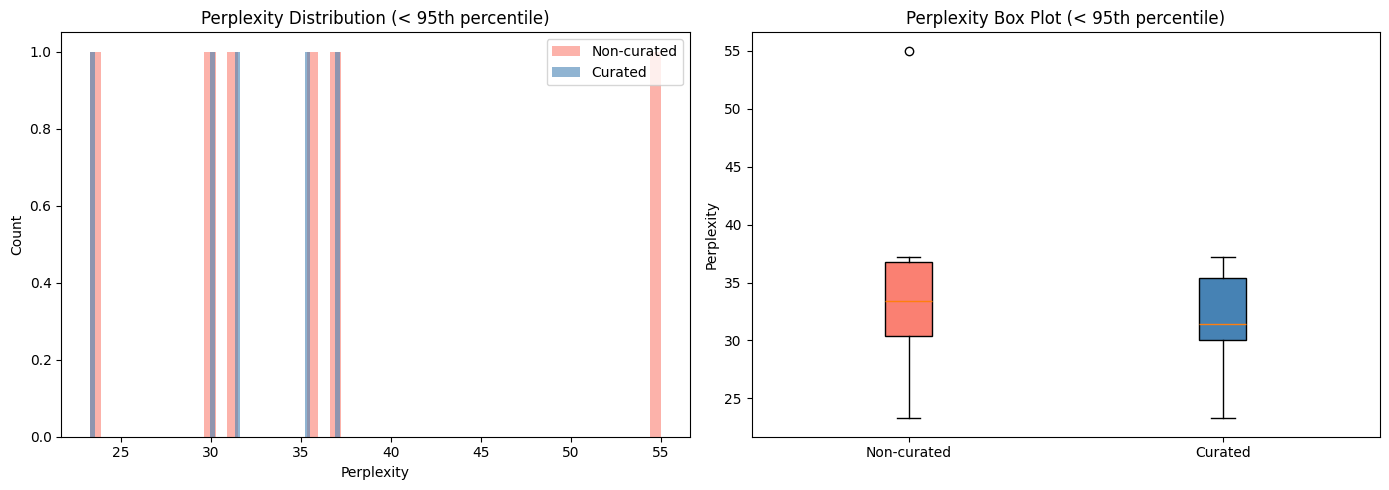

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from nemo_curator.utils.file_utils import get_all_file_paths_under

def load_perplexities(data_dir):
    file_paths = get_all_file_paths_under(data_dir)
    dfs = [pd.read_json(fp, lines=True) for fp in file_paths]
    return pd.concat(dfs, ignore_index=True)["perplexity"].values

nc_perp = load_perplexities(non_curated_perplexity_dir)
c_perp = load_perplexities(curated_perplexity_dir)

print(f"Non-curated: n={len(nc_perp)}, mean={np.mean(nc_perp):.2f}, median={np.median(nc_perp):.2f}")
print(f"Curated:     n={len(c_perp)}, mean={np.mean(c_perp):.2f}, median={np.median(c_perp):.2f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram comparison
cap = np.percentile(np.concatenate([nc_perp, c_perp]), 95)
axes[0].hist(nc_perp[nc_perp < cap], bins=50, alpha=0.6, label="Non-curated", color="salmon")
axes[0].hist(c_perp[c_perp < cap], bins=50, alpha=0.6, label="Curated", color="steelblue")
axes[0].set_xlabel("Perplexity")
axes[0].set_ylabel("Count")
axes[0].set_title("Perplexity Distribution (< 95th percentile)")
axes[0].legend()

# Box plot comparison
bp = axes[1].boxplot(
    [nc_perp[nc_perp < cap], c_perp[c_perp < cap]],
    labels=["Non-curated", "Curated"],
    patch_artist=True,
)
bp["boxes"][0].set_facecolor("salmon")
bp["boxes"][1].set_facecolor("steelblue")
axes[1].set_ylabel("Perplexity")
axes[1].set_title("Perplexity Box Plot (< 95th percentile)")

plt.tight_layout()
plt.show()

You are invited to experiment with other methods to evaluate the non-curated versus curated datasets. Include them below.

In [ ]:
# additional explorations here

## Conclusion

Reason about the assignment and/or your findings here.

Once you are done with any Curator-related pipelines, stop the Ray client with:

In [48]:
ray_client.stop()

2026-02-26 01:21:37.948 | INFO     | nemo_curator.core.client:stop:198 - NeMo Curator has stopped the Ray cluster it started by killing the Ray GCS process. It is advised to wait for a few seconds before running any Ray commands to ensure Ray can cleanup other processes.If you are seeing any Ray commands like `ray status` failing, please ensure /tmp/ray/ray_current_cluster has correct information.
